In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from timeit import default_timer
from tqdm import tqdm
from torch import optim

from dataset import *
from model import *
from metrics import *
from utils import get_dataset, get_loader, process_data, down_sample, train_model

# label * mask
# 在训练时 label 和 target 仅提取非掩码值
# 如何从FNN的输出reshape为原来的形状？

In [ ]:
def test_model(model, test_loader, device, args, metric_names=['MSE', 'RMSE', 'MaxError',]):
    '''
    test model
    
    '''
    k = args['model']['out_dim']  # k: depth

    # 创建字典，用于存储结果
    res_list_all = {}
    res_list_depth = {}
    res_list_seq = {}
    for name in metric_names:
        res_list_all[name] = []  
    
    # load model
    model_name = args['model']['model_name']
    saved_model_name = args["challenge_name"] + '_' + args['dataset']['region_name'] + '_' + model_name
    saved_path = os.path.join(args['saved_dir'], saved_model_name)
    print(f"Test mode, load checkpoint from {saved_path}-best.pt")
    checkpoint = torch.load(saved_path + "-best.pt")
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)
    
    # start testing
    model.eval()
    t1 = default_timer()  # start time

    with torch.no_grad():
        for inputs, targets, _, _, _ in test_loader:

            # prepare data
            if model_name == 'FNN':
                bs, depth, _, _ = targets.shape
                inputs, targets = process_data(inputs, targets, k, lstm = False)  # [bs, var, lat, lon] --> [bs, n]
            elif model_name == 'LSTM':
                bs, seq_len, depth, _, _ = targets.shape
                inputs, targets = process_data(inputs, targets, k, lstm = True)   # [bs, seq, var, lat, lon] --> [bs, seq, n]  torch.Size([1, 5, 16200])
            elif model_name == 'UNET':
                inputs, targets, _, _ = down_sample(inputs, targets)  # [bs, var, new_lat, new_lon]  torch.Size([1, 12, 27, 50]
                inputs, targets = inputs, targets[:, 0:k, ...]
            elif model_name == 'Earthformer':  # [1, 5, 12, 108, 200]
                inputs, targets, _, _ = down_sample(inputs, targets)
                inputs, targets = inputs.permute(0, 1, 3, 4, 2), targets[:, 0:k, ...].permute(0, 1, 3, 4, 2)
            else:
                raise NotImplementedError
            
            # evaluate
            inputs, targets = inputs.to(device) , targets.to(device)  
            pred = model(inputs)
            
            # 将 pred target 转化为[bs, seq, depth, -1]
            if model_name == 'LSTM':
                # torch.Size([bs, seq, n]) --> [bs, seq, depth, -1] 
                pred, targets = pred.reshape(bs, seq_len, depth, -1), targets.reshape(bs, seq_len, depth, -1)
            elif model_name == 'FNN':
                # torch.Size([bs, n]) --> [bs, 1, depth, -1] 
                pred, targets = pred.reshape(bs, depth, -1).unsqueeze(1), targets.reshape(bs, depth, -1).unsqueeze(1)
            elif model_name == 'UNET':
                # torch.Size([bs, depth, lat, lon]) --> [bs, 1, depth, -1]
                bs, depth, _, _ = targets.shape
                pred, targets = pred.reshape(bs, depth, -1).unsqueeze(1), targets.reshape(bs, depth, -1).unsqueeze(1)
            elif model_name == 'Earthformer': 
                # torch.Size([bs, seq, lat, lon, depth]) --> [bs, seq, depth, -1] 
                bs, seq_len, _, _, depth = targets.shape
                pred, targets = pred.reshape(bs, seq_len, -1, depth).permute(0, 1, 3, 2), targets.reshape(bs, seq_len, -1, depth).permute(0, 1, 3, 2)

            # calculate metrics
            res = calculate_res(pred, targets, metric_names)  # list of metrics  [bs, seq, depth]
            # print(res)
            for name in metric_names:
                res_list_all[name].append(res[name])

    for name in metric_names:
        # 在seq维度拼接起来
        res_list_all[name] = torch.concatenate(res_list_all[name])[0, ...]  # [seq_len, depth], bs = 1
        # 在拼接的维度求均值
        if name == 'MaxError':
            res_list_depth[name] = torch.max(res_list_all[name], dim=0).values  # [bs, depth]
            res_list_seq[name] = torch.max(res_list_all[name], dim=1).values  # [bs, seq]
            res_list_all[name] = torch.max(res_list_all[name])  
        else:
            res_list_depth[name] = torch.mean(res_list_all[name], dim=0)  # [depth]
            res_list_seq[name] = torch.mean(res_list_all[name], dim=1)  # [seq]
            res_list_all[name] = torch.mean(res_list_all[name])  
            

    t2 = default_timer()  # end time
    inference_time = (t2-t1)/len(test_loader.dataset)
    
    for name in metric_names:
        print(f"average {name}: {res_list_all[name]}")
        print(f"depth {name}: {res_list_depth[name].shape}")
        print(f"seq_len {name}: {res_list_seq[name]}")
    print(res_list_all)
    print("Testing time: {}".format(inference_time))

    
  
# LSTM：[batch_size, seq_len, n]
# FNN: [bs, n]
# UNET: [bs, var, lat, lon]
# earthformer: [bs, seq, var, lat, lon]

## Dataset

In [ ]:
# 分割train val test
# FNN，seq_len = 0
# 按照年份分割数据

import yaml

config_file = './config/ST_Gulf_FNN.yaml'
with open(config_file, 'r') as f:
    args = yaml.safe_load(f)

train_data, test_data = get_dataset(args)
train_loader, val_loader, test_loader = get_loader(train_data, test_data, args)

print('len(train_loader): ', len(train_loader))
print('len(validate_loader)', len(val_loader))
print('len(test_loader)', len(test_loader))

Processing file: /home/data2/pengguohang/My_Ocean/challenge/vwnd_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/sss_cci_monthly_201001_201912_data.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/swh_monthly_201001_201912_data.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/oisst_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/uwnd_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/sla_monthly_201001_201901.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/adt_monthly_201001-201912.nc
shape of variable:  torch.Size([99, 12, 54, 100]) torch.Size([99, 36, 54, 100]) torch.Size([54]) torch.Size([100]) torch.Size([36])
Processing file: /home/data2/pengguohang/My_Ocean/challenge/vwnd_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/sss_cci_monthly_201001_201912_data.nc
Processing file: /home/data2/pengguohan

In [ ]:
for data in train_loader:
    input = data[0]
    label = data[1]
    mask = data[2]
    lat = data[3]
    lon = data[4]
    depth = data[5]
    print('input, label:', input.shape, label.shape)
    print('depth: ', depth)
    print('lat:', lat, lon)
    break

input, label: torch.Size([1, 12, 54, 100]) torch.Size([1, 36, 54, 100])
depth:  tensor([[   0,    5,   10,   15,   20,   25,   30,   35,   40,   45,   50,   55,
           60,   65,   70,   80,   90,  100,  125,  150,  175,  200,  225,  250,
          275,  300,  350,  400,  450,  500,  550,  600,  700,  800,  900, 1000]],
       dtype=torch.int16)
lat: tensor([[23.1250, 23.6250, 24.1250, 24.6250, 25.1250, 25.6250, 26.1250, 26.6250,
         27.1250, 27.6250, 28.1250, 28.6250, 29.1250, 29.6250, 30.1250, 30.6250,
         31.1250, 31.6250, 32.1250, 32.6250, 33.1250, 33.6250, 34.1250, 34.6250,
         35.1250, 35.6250, 36.1250, 36.6250, 37.1250, 37.6250, 38.1250, 38.6250,
         39.1250, 39.6250, 40.1250, 40.6250, 41.1250, 41.6250, 42.1250, 42.6250,
         43.1250, 43.6250, 44.1250, 44.6250, 45.1250, 45.6250, 46.1250, 46.6250,
         47.1250, 47.6250, 48.1250, 48.6250, 49.1250, 49.6250]]) tensor([[-79.6250, -79.1250, -78.6250, -78.1250, -77.6250, -77.1250, -76.6250,
         -76.1

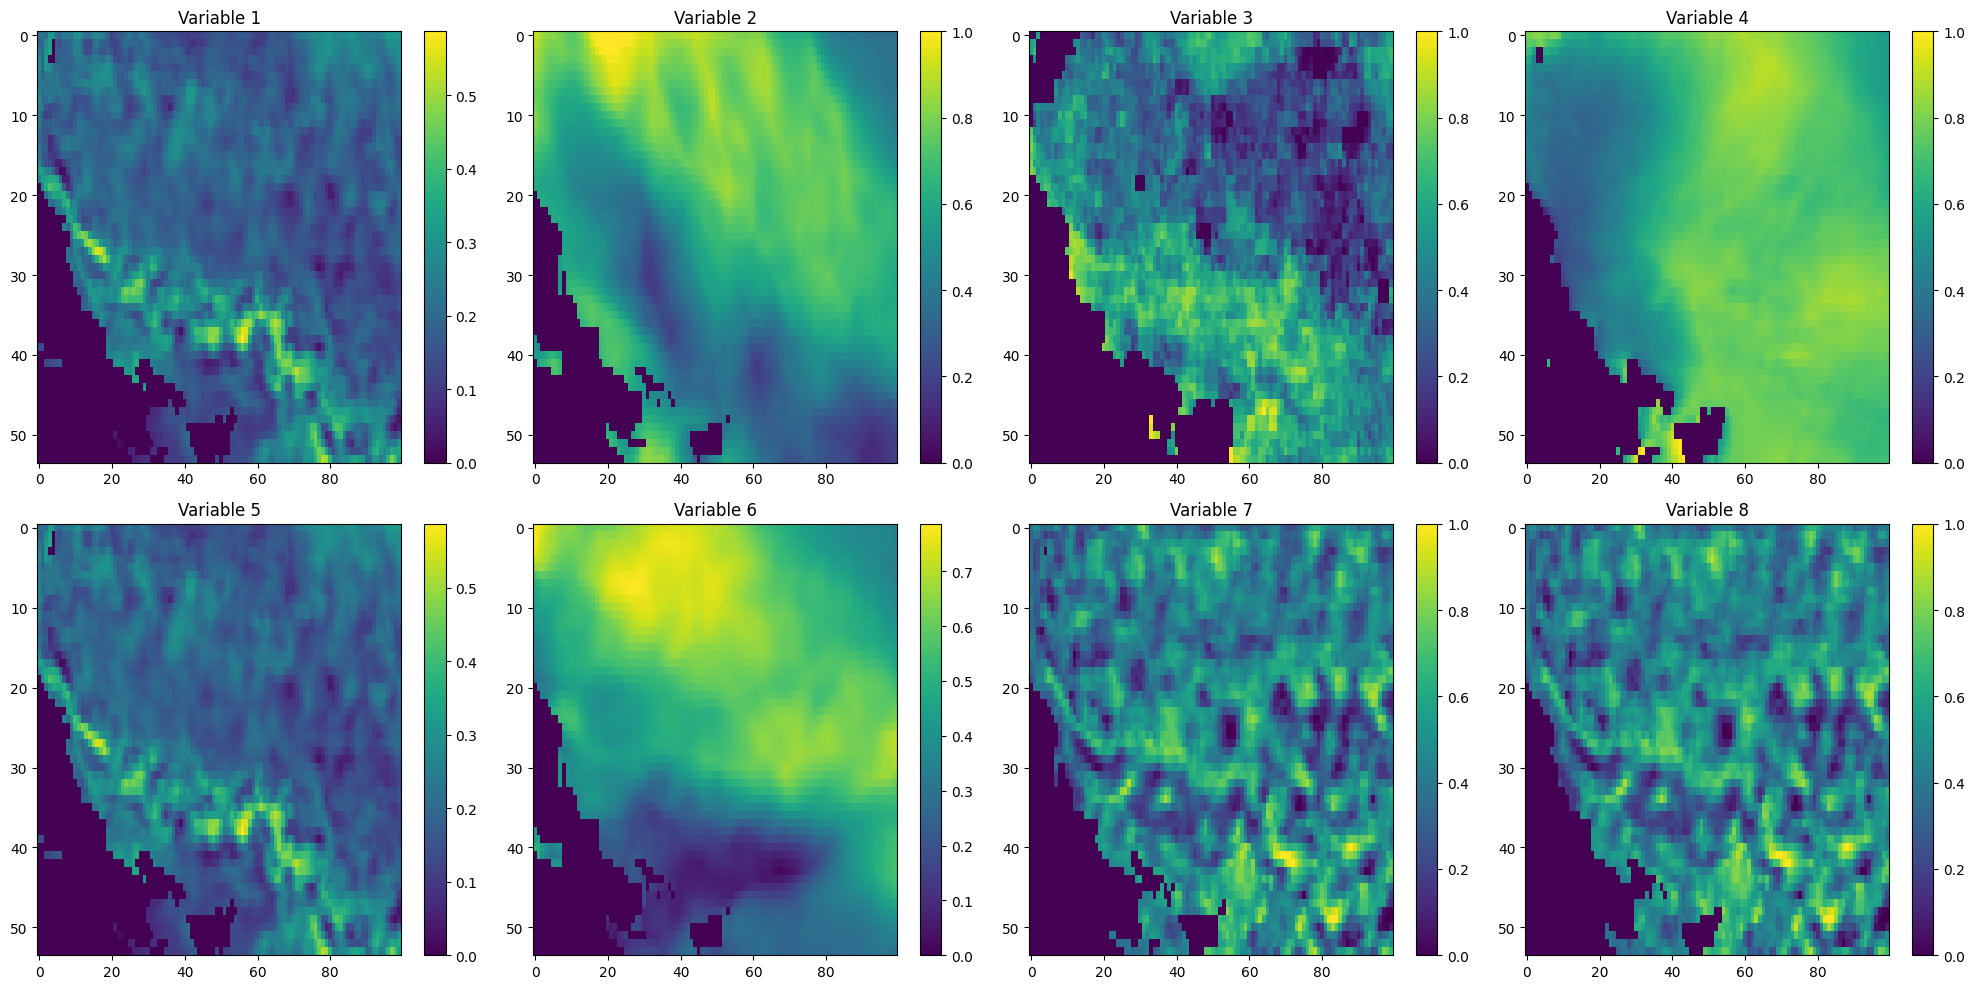

In [ ]:
# 查看我的输入

def plot_ocean_data(data, i):
    data = data[i, ...]
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))

    # 绘制每个变量
    for i in range(8):
        # print(data[i].shape)
        ax = axes[i // 4, i % 4]
        im = ax.imshow(data[i], aspect='auto')
        ax.set_title(f'Variable {i+1}')
        fig.colorbar(im, ax=ax)
        
        # 显示图像
    plt.tight_layout()
    plt.show()

plot_ocean_data(input, 0)

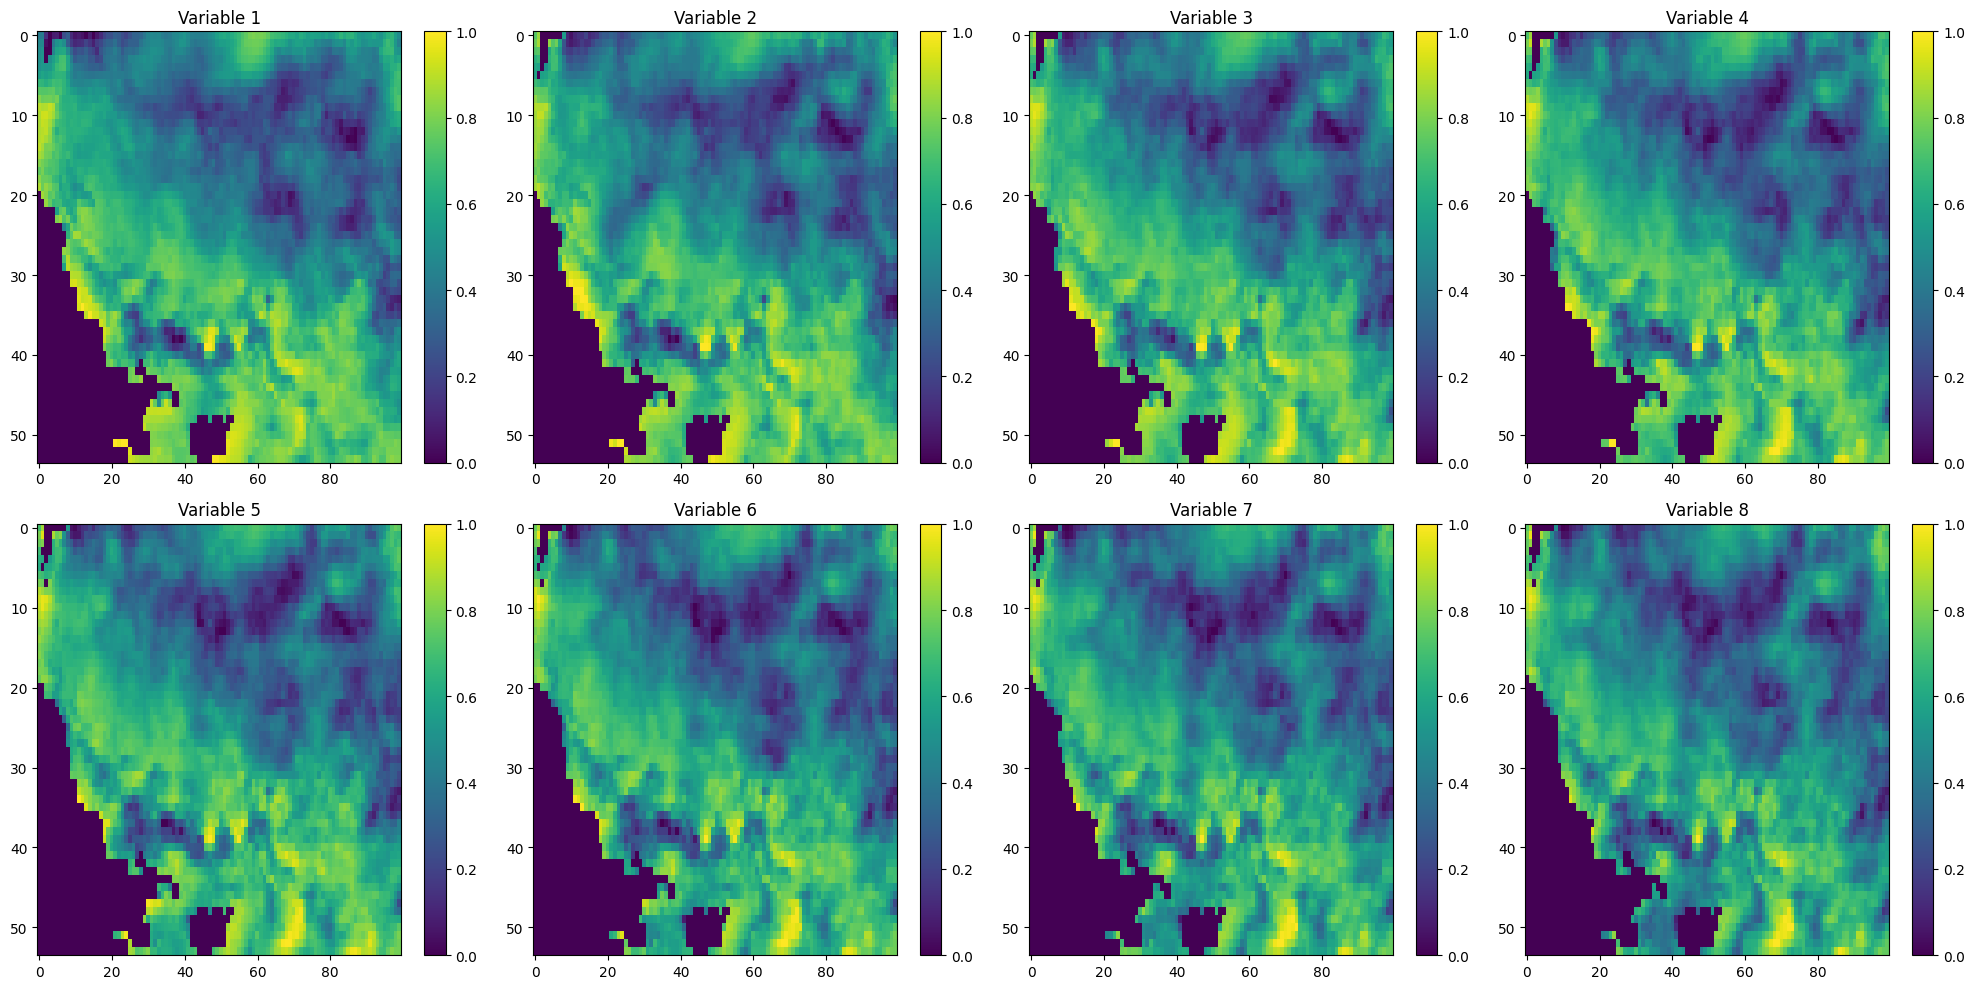

In [ ]:
# 3 绘制前八个层
for i in range(label.shape[1]):
    data = label[0, i, ...]
    nan = np.isnan(data).reshape(-1)
    judge = all(item == 1 for item in nan)
    if judge:
        print(f'第{i+1}层全为nan')


plot_ocean_data(label, 0)

## LSTM

input:  (batch_size, seq_len, var\*lat*lon)  torch.Size([1, 5, 16200]) 

output: (batch_size, seq_len, depth\*lat*lon)  torch.Size([1, 5, 13500])



In [ ]:
import yaml

config_file = './config/ST_Gulf_LSTM.yaml'
with open(config_file, 'r') as f:
    args = yaml.safe_load(f)

train_data, test_data = get_dataset(args)
train_loader, val_loader, test_loader = get_loader(train_data, test_data, args)

print('len(train_loader): ', len(train_loader))
print('len(validate_loader)', len(val_loader))
print('len(test_loader)', len(test_loader))

for data in train_loader:
    input = data[0]
    label = data[1]
    mask = data[2]
    n_channels = input.shape[1]
    n_classes = label.shape[1]

    print('input, label:', input.shape, label.shape)
    print('mask: ', mask.shape)
    break

Processing file: /home/data2/pengguohang/My_Ocean/challenge/vwnd_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/sss_cci_monthly_201001_201912_data.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/swh_monthly_201001_201912_data.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/oisst_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/uwnd_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/sla_monthly_201001_201901.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/adt_monthly_201001-201912.nc
shape of variable:  torch.Size([19, 5, 12, 54, 100]) torch.Size([19, 5, 36, 54, 100]) torch.Size([54]) torch.Size([100]) torch.Size([36])
Processing file: /home/data2/pengguohang/My_Ocean/challenge/vwnd_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/sss_cci_monthly_201001_201912_data.nc
Processing file: /home/data2/peng

In [ ]:
# input, label: torch.Size([21, 5, 12, 108, 200]) torch.Size([21, 5, 36, 108, 200])
# after process:
# input, label: torch.Size([5, 270, 5, 12]) torch.Size([5, 270, 5, 3])

# LSTM输入数据：[batch_size, seq_len, input_size]

device = torch.device(args['device'] if torch.cuda.is_available() else "cpu")
k = args['model']['out_dim']
for inputs, targets, _, _, _ in train_loader:
    inputs, targets = process_data(inputs, targets, k, lstm=True)
    input_dim = inputs.shape[-1]
    output_dim = targets.shape[-1]
    break

n_units1 = args['model']['n_units1']
n_units2 = args['model']['n_units2']
dropout_fraction = args['model']['dropout_fraction']
activ = args['model']['activ']

model = LSTMModel(input_dim, output_dim, n_units1, n_units2, dropout_fraction, activ).to(device)

criterion = nn.MSELoss()


for inputs, targets, mask, _, _ in train_loader:
    inputs, targets, mask = inputs.to(device), targets.to(device), mask.to(device)
    # print('x, y: ', x.shape, y.shape, mask.shape)
    loss, pred, info = model.train_one_step(inputs, targets, mask, criterion, k)
    # print(loss)
    

In [ ]:
# input, label: torch.Size([21, 5, 12, 108, 200]) torch.Size([21, 5, 36, 108, 200])
# after process:
# input, label: torch.Size([5, 270, 5, 12]) torch.Size([5, 270, 5, 3])

# LSTM输入数据：[batch_size, seq_len, input_size]

device = torch.device(args['device'] if torch.cuda.is_available() else "cpu")
k = args['model']['out_dim']
for inputs, targets, _, _, _ in train_loader:
    inputs, targets = process_data(inputs, targets, k, lstm=True)
    input_dim = inputs.shape[-1]
    output_dim = targets.shape[-1]
    break

n_units1 = args['model']['n_units1']
n_units2 = args['model']['n_units2']
dropout_fraction = args['model']['dropout_fraction']
activ = args['model']['activ']

model = LSTMModel(input_dim, output_dim, n_units1, n_units2, dropout_fraction, activ).to(device)

criterion = nn.MSELoss()


train_model(model, train_loader, val_loader, criterion, device, args)

 10%|█         | 1/10 [00:21<03:09, 21.01s/it]

Epoch 1/10, Training Loss: 0.0920, Validation Loss: 0.0622, Time: 1.50s


 20%|██        | 2/10 [00:40<02:41, 20.15s/it]

Epoch 2/10, Training Loss: 0.0581, Validation Loss: 0.0584, Time: 1.41s


 30%|███       | 3/10 [01:00<02:21, 20.18s/it]

Epoch 3/10, Training Loss: 0.0580, Validation Loss: 0.0576, Time: 1.40s


 40%|████      | 4/10 [01:02<01:16, 12.78s/it]

Epoch 4/10, Training Loss: 0.0585, Validation Loss: 0.0581, Time: 1.41s


 50%|█████     | 5/10 [01:03<00:43,  8.68s/it]

Epoch 5/10, Training Loss: 0.0594, Validation Loss: 0.0588, Time: 1.40s


 60%|██████    | 6/10 [01:05<00:24,  6.21s/it]

Epoch 6/10, Training Loss: 0.0597, Validation Loss: 0.0591, Time: 1.40s


 70%|███████   | 7/10 [01:06<00:13,  4.64s/it]

Epoch 7/10, Training Loss: 0.0603, Validation Loss: 0.0603, Time: 1.40s


 80%|████████  | 8/10 [01:07<00:07,  3.61s/it]

Epoch 8/10, Training Loss: 0.0607, Validation Loss: 0.0598, Time: 1.39s


 90%|█████████ | 9/10 [01:09<00:02,  2.92s/it]

Epoch 9/10, Training Loss: 0.0610, Validation Loss: 0.0610, Time: 1.39s


100%|██████████| 10/10 [01:10<00:00,  7.07s/it]

Epoch 10/10, Training Loss: 0.0611, Validation Loss: 0.0607, Time: 1.39s
avg_time : 1.40843


In [ ]:
# # input, label: torch.Size([21, 5, 12, 108, 200]) torch.Size([21, 5, 36, 108, 200])
# # after process:
# # input, label: torch.Size([5, 270, 5, 12]) torch.Size([5, 270, 5, 3])

# # LSTM输入数据：[batch_size, seq_len, input_size]

# device = torch.device(args['device'] if torch.cuda.is_available() else "cpu")
# k = args['model']['out_dim']
# for inputs, targets, _, _, _ in train_loader:
#     inputs, targets = process_data(inputs, targets, k, lstm=True)
#     input_dim = inputs.shape[-1]
#     output_dim = targets.shape[-1]
#     break

# n_units1 = args['model']['n_units1']
# n_units2 = args['model']['n_units2']
# dropout_fraction = args['model']['dropout_fraction']
# activ = args['model']['activ']

# model = LSTMModel(input_dim, output_dim, n_units1, n_units2, dropout_fraction, activ).to(device)

# criterion = nn.MSELoss()


# train_model(model, train_loader, val_loader, criterion, device, args)

 10%|█         | 1/10 [00:19<02:59, 19.91s/it]

Epoch 1/10, Training Loss: 0.0957, Validation Loss: 0.0652, Time: 1.39s


 20%|██        | 2/10 [00:39<02:36, 19.59s/it]

Epoch 2/10, Training Loss: 0.0597, Validation Loss: 0.0607, Time: 1.40s


 30%|███       | 3/10 [00:59<02:18, 19.82s/it]

Epoch 3/10, Training Loss: 0.0595, Validation Loss: 0.0593, Time: 1.40s


 40%|████      | 4/10 [01:00<01:15, 12.56s/it]

Epoch 4/10, Training Loss: 0.0600, Validation Loss: 0.0595, Time: 1.41s


 50%|█████     | 5/10 [01:02<00:42,  8.54s/it]

Epoch 5/10, Training Loss: 0.0609, Validation Loss: 0.0599, Time: 1.39s


 60%|██████    | 6/10 [01:03<00:24,  6.12s/it]

Epoch 6/10, Training Loss: 0.0614, Validation Loss: 0.0610, Time: 1.40s


 70%|███████   | 7/10 [01:05<00:13,  4.58s/it]

Epoch 7/10, Training Loss: 0.0616, Validation Loss: 0.0608, Time: 1.39s


 80%|████████  | 8/10 [01:06<00:07,  3.57s/it]

Epoch 8/10, Training Loss: 0.0617, Validation Loss: 0.0619, Time: 1.39s


 90%|█████████ | 9/10 [01:07<00:02,  2.89s/it]

Epoch 9/10, Training Loss: 0.0621, Validation Loss: 0.0609, Time: 1.39s


100%|██████████| 10/10 [01:09<00:00,  6.93s/it]

Epoch 10/10, Training Loss: 0.0622, Validation Loss: 0.0626, Time: 1.39s
avg_time : 1.39675


In [ ]:
device = torch.device(args['device'] if torch.cuda.is_available() else "cpu")
k = args['model']['out_dim']
for inputs, targets, _, _, _ in train_loader:
    inputs, targets = process_data(inputs, targets, k, lstm=True)
    input_dim = inputs.shape[-1]
    output_dim = targets.shape[-1]
    break

n_units1 = args['model']['n_units1']
n_units2 = args['model']['n_units2']
dropout_fraction = args['model']['dropout_fraction']
activ = args['model']['activ']

model = LSTMModel(input_dim, output_dim, n_units1, n_units2, dropout_fraction, activ).to(device)

criterion = nn.MSELoss()

test_model(model, val_loader, device, args)

Test mode, load checkpoint from /home/data2/pengguohang/My_Ocean/challenge/checkpoint/SS_Gulf_LSTM-best.pt
average MSE: 0.05938760191202164
depth MSE: torch.Size([36])
seq_len MSE: tensor([0.0606, 0.0532, 0.0576, 0.0620, 0.0636], device='cuda:4')
average RMSE: 0.23897209763526917
depth RMSE: torch.Size([36])
seq_len RMSE: tensor([0.2403, 0.2271, 0.2376, 0.2424, 0.2474], device='cuda:4')
average MaxError: 1.135498285293579
depth MaxError: torch.Size([36])
seq_len MaxError: tensor([1.1355, 1.0029, 1.0196, 1.1121, 1.0354], device='cuda:4')
{'MSE': tensor(0.0594, device='cuda:4'), 'RMSE': tensor(0.2390, device='cuda:4'), 'MaxError': tensor(1.1355, device='cuda:4')}
Testing time: 0.03566223196685314


## FNN

input:  (batch_size, var\*lat*lon)  torch.Size([1, 16200]) 

output: (batch_size, depth\*lat*lon)  torch.Size([1, 13500])

In [ ]:
import yaml

config_file = './config/ST_Gulf_FNN.yaml'
with open(config_file, 'r') as f:
    args = yaml.safe_load(f)

train_data, test_data = get_dataset(args)
train_loader, val_loader, test_loader = get_loader(train_data, test_data, args)

print('len(train_loader): ', len(train_loader))
print('len(validate_loader)', len(val_loader))
print('len(test_loader)', len(test_loader))

for data in train_loader:
    input = data[0]
    label = data[1]
    mask = data[2]
    lon = data[3]
    depth = data[4]
    n_channels = input.shape[1]
    n_classes = label.shape[1]

    print('input, label:', input.shape, label.shape)
    print('mask:', mask.shape, mask)
    break

Processing file: /home/data2/pengguohang/My_Ocean/challenge/vwnd_monthly_201001-201904.nc


Processing file: /home/data2/pengguohang/My_Ocean/challenge/sss_cci_monthly_201001_201912_data.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/swh_monthly_201001_201912_data.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/oisst_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/uwnd_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/sla_monthly_201001_201901.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/adt_monthly_201001-201912.nc
shape of variable:  torch.Size([99, 12, 54, 100]) torch.Size([99, 36, 54, 100]) torch.Size([54]) torch.Size([100]) torch.Size([36])
Processing file: /home/data2/pengguohang/My_Ocean/challenge/vwnd_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/sss_cci_monthly_201001_201912_data.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/swh_monthly_201001_201912_data.nc
Processing file: /home/data2/penggu

In [ ]:
device = torch.device(args['device'] if torch.cuda.is_available() else "cpu")
k = args['model']['out_dim']  # depth
for inputs, targets, _, _, _ in train_loader:
    inputs, targets = process_data(inputs, targets, k)
    in_dim = inputs.shape[1]
    out_dim = targets.shape[1]
    print(in_dim, targets.shape)
    break

n_units1 = args['model']['n_units1']
n_units2 = args['model']['n_units2']
dropout_fraction = args['model']['dropout_fraction']
activ = args['model']['activ']
model = FFNN(in_dim, out_dim, n_units1, n_units2, dropout_fraction, activ).to(device)

criterion = nn.MSELoss()

for inputs, targets, mask, _, _ in train_loader:
    inputs, targets, mask = inputs.to(device), targets.to(device), mask.to(device)
    loss, pred, info = model.train_one_step(inputs, targets, mask, criterion, k)
    # print(loss)

64800 torch.Size([1, 194400])


In [ ]:
device = torch.device(args['device'] if torch.cuda.is_available() else "cpu")
k = args['model']['out_dim']  # depth
for inputs, targets, _, _, _ in train_loader:
    inputs, targets = process_data(inputs, targets, k)
    in_dim = inputs.shape[1]
    out_dim = targets.shape[1]
    print(in_dim, targets.shape)
    break

n_units1 = args['model']['n_units1']
n_units2 = args['model']['n_units2']
dropout_fraction = args['model']['dropout_fraction']
activ = args['model']['activ']
model = FFNN(in_dim, out_dim, n_units1, n_units2, dropout_fraction, activ).to(device)

criterion = nn.MSELoss()

train_model(model, train_loader, val_loader, criterion, device, args)


64800 torch.Size([1, 194400])


 10%|█         | 1/10 [00:13<02:03, 13.69s/it]

Epoch 1/10, Training Loss: 0.0532, Validation Loss: 0.0444, Time: 3.67s


 20%|██        | 2/10 [00:17<01:02,  7.83s/it]

Epoch 2/10, Training Loss: 0.0453, Validation Loss: 0.0460, Time: 3.69s


 30%|███       | 3/10 [00:21<00:41,  5.94s/it]

Epoch 3/10, Training Loss: 0.0443, Validation Loss: 0.0467, Time: 3.66s


 40%|████      | 4/10 [00:34<00:54,  9.07s/it]

Epoch 4/10, Training Loss: 0.0439, Validation Loss: 0.0443, Time: 3.67s


 50%|█████     | 5/10 [00:38<00:35,  7.15s/it]

Epoch 5/10, Training Loss: 0.0439, Validation Loss: 0.0459, Time: 3.73s


 60%|██████    | 6/10 [00:52<00:37,  9.40s/it]

Epoch 6/10, Training Loss: 0.0423, Validation Loss: 0.0423, Time: 3.66s


 70%|███████   | 7/10 [00:56<00:22,  7.57s/it]

Epoch 7/10, Training Loss: 0.0426, Validation Loss: 0.0453, Time: 3.77s


 80%|████████  | 8/10 [00:59<00:12,  6.34s/it]

Epoch 8/10, Training Loss: 0.0422, Validation Loss: 0.0446, Time: 3.67s


 90%|█████████ | 9/10 [01:03<00:05,  5.52s/it]

Epoch 9/10, Training Loss: 0.0433, Validation Loss: 0.0442, Time: 3.68s


100%|██████████| 10/10 [01:07<00:00,  6.74s/it]

Epoch 10/10, Training Loss: 0.0433, Validation Loss: 0.0474, Time: 3.66s
avg_time : 3.68628


In [ ]:
# device = torch.device(args['device'] if torch.cuda.is_available() else "cpu")
# k = args['model']['out_dim']  # depth
# for inputs, targets, _, _, _ in train_loader:
#     inputs, targets = process_data(inputs, targets, k)
#     in_dim = inputs.shape[1]
#     out_dim = targets.shape[1]
#     print(in_dim, targets.shape)
#     break

# n_units1 = args['model']['n_units1']
# n_units2 = args['model']['n_units2']
# dropout_fraction = args['model']['dropout_fraction']
# activ = args['model']['activ']
# model = FFNN(in_dim, out_dim, n_units1, n_units2, dropout_fraction, activ).to(device)

# criterion = nn.MSELoss()

# train_model(model, train_loader, val_loader, criterion, device, args)


64800 torch.Size([1, 194400])


 10%|█         | 1/10 [00:13<02:03, 13.71s/it]

Epoch 1/10, Training Loss: 0.0531, Validation Loss: 0.0439, Time: 3.71s


 20%|██        | 2/10 [00:17<01:02,  7.82s/it]

Epoch 2/10, Training Loss: 0.0454, Validation Loss: 0.0443, Time: 3.66s


 30%|███       | 3/10 [00:21<00:41,  5.92s/it]

Epoch 3/10, Training Loss: 0.0465, Validation Loss: 0.0453, Time: 3.64s


 40%|████      | 4/10 [00:24<00:30,  5.03s/it]

Epoch 4/10, Training Loss: 0.0448, Validation Loss: 0.0448, Time: 3.64s


 50%|█████     | 5/10 [00:28<00:22,  4.54s/it]

Epoch 5/10, Training Loss: 0.0437, Validation Loss: 0.0452, Time: 3.65s


 60%|██████    | 6/10 [00:32<00:16,  4.25s/it]

Epoch 6/10, Training Loss: 0.0433, Validation Loss: 0.0471, Time: 3.65s


 70%|███████   | 7/10 [00:35<00:12,  4.06s/it]

Epoch 7/10, Training Loss: 0.0427, Validation Loss: 0.0461, Time: 3.65s


 80%|████████  | 8/10 [00:39<00:07,  3.94s/it]

Epoch 8/10, Training Loss: 0.0435, Validation Loss: 0.0446, Time: 3.65s


 90%|█████████ | 9/10 [00:53<00:06,  6.98s/it]

Epoch 9/10, Training Loss: 0.0433, Validation Loss: 0.0426, Time: 3.64s


100%|██████████| 10/10 [01:06<00:00,  6.67s/it]

Epoch 10/10, Training Loss: 0.0425, Validation Loss: 0.0417, Time: 3.66s
avg_time : 3.65405


In [ ]:
test_model(model, val_loader, device, args)

Test mode, load checkpoint from /home/data2/pengguohang/My_Ocean/challenge/checkpoint/SS_Gulf_FNN-best.pt
average MSE: 0.03714172914624214
depth MSE: torch.Size([36])
seq_len MSE: tensor([0.0371], device='cuda:4')
average RMSE: 0.18514223396778107
depth RMSE: torch.Size([36])
seq_len RMSE: tensor([0.1851], device='cuda:4')
average MaxError: 0.7776217460632324
depth MaxError: torch.Size([36])
seq_len MaxError: tensor([0.7776], device='cuda:4')
{'MSE': tensor(0.0371, device='cuda:4'), 'RMSE': tensor(0.1851, device='cuda:4'), 'MaxError': tensor(0.7776, device='cuda:4')}
Testing time: 0.002923654578626156


## UNet

input:  (batch_size, var, lat, lon)  torch.Size([1, 12, 108, 200])

output:  (batch_size, depth, lat, lon)   torch.Size([1, 36, 108, 200])



In [ ]:
import yaml

config_file = './config/ST_Gulf_UNET.yaml'
with open(config_file, 'r') as f:
    args = yaml.safe_load(f)

train_data, test_data = get_dataset(args)
train_loader, val_loader, test_loader = get_loader(train_data, test_data, args)

print('len(train_loader): ', len(train_loader))
print('len(validate_loader)', len(val_loader))
print('len(test_loader)', len(test_loader))

for data in train_loader:
    input = data[0]
    label = data[1]
    lat = data[2]
    lon = data[3]
    depth = data[4]
    n_channels = input.shape[1]
    n_classes = label.shape[1]

    print('input, label:', input.shape, label.shape)
    print('lat:', lat.shape, lon.shape)
    break

Processing file: /home/data2/pengguohang/My_Ocean/challenge/vwnd_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/sss_cci_monthly_201001_201912_data.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/swh_monthly_201001_201912_data.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/oisst_monthly_201001-201904.nc


KeyboardInterrupt: 

In [ ]:
device = torch.device(args['device'] if torch.cuda.is_available() else 'cpu')

n_channels = args['model']['in_dim']
n_classes = args['model']['out_dim']

model = UNet(n_channels, n_classes, bilinear=False).to(device)
criterion = nn.MSELoss()


for inputs, targets, mask, _, _ in train_loader:
    inputs, targets, mask = inputs.to(device), targets.to(device), mask.to(device)
    loss, pred, info = model.train_one_step(inputs, targets, mask, criterion, k)
    # print(loss)


In [ ]:
device = torch.device(args['device'] if torch.cuda.is_available() else 'cpu')

n_channels = args['model']['in_dim']
n_classes = args['model']['out_dim']

model = UNet(n_channels, n_classes, bilinear=False).to(device)
criterion = nn.MSELoss()


train_model(model, train_loader, val_loader, criterion, device, args)


 10%|█         | 1/10 [00:01<00:15,  1.69s/it]

Epoch 1/10, Training Loss: 0.1021, Validation Loss: 22.2175, Time: 1.17s


 20%|██        | 2/10 [00:03<00:12,  1.60s/it]

Epoch 2/10, Training Loss: 0.0448, Validation Loss: 0.0477, Time: 1.12s


 30%|███       | 3/10 [00:04<00:11,  1.58s/it]

Epoch 3/10, Training Loss: 0.0419, Validation Loss: 0.0461, Time: 1.12s


 40%|████      | 4/10 [00:06<00:09,  1.54s/it]

Epoch 4/10, Training Loss: 0.0402, Validation Loss: 0.0450, Time: 1.06s


 50%|█████     | 5/10 [00:07<00:07,  1.57s/it]

Epoch 5/10, Training Loss: 0.0388, Validation Loss: 0.0441, Time: 1.14s


 60%|██████    | 6/10 [00:08<00:05,  1.41s/it]

Epoch 6/10, Training Loss: 0.0377, Validation Loss: 0.0453, Time: 1.06s


 70%|███████   | 7/10 [00:10<00:04,  1.35s/it]

Epoch 7/10, Training Loss: 0.0368, Validation Loss: 0.0466, Time: 1.16s


 80%|████████  | 8/10 [00:11<00:02,  1.30s/it]

Epoch 8/10, Training Loss: 0.0359, Validation Loss: 0.0480, Time: 1.15s


 90%|█████████ | 9/10 [00:12<00:01,  1.25s/it]

Epoch 9/10, Training Loss: 0.0352, Validation Loss: 0.0533, Time: 1.12s


100%|██████████| 10/10 [00:13<00:00,  1.38s/it]

Epoch 10/10, Training Loss: 0.0346, Validation Loss: 0.0621, Time: 1.16s
avg_time : 1.12608


In [ ]:
# device = torch.device(args['device'] if torch.cuda.is_available() else 'cpu')

# n_channels = args['model']['in_dim']
# n_classes = args['model']['out_dim']

# model = UNet(n_channels, n_classes, bilinear=False).to(device)
# criterion = nn.MSELoss()


# train_model(model, train_loader, val_loader, criterion, device, args)


 10%|█         | 1/10 [00:01<00:16,  1.83s/it]

Epoch 1/10, Training Loss: 0.0944, Validation Loss: 0.0512, Time: 1.34s


 20%|██        | 2/10 [00:03<00:13,  1.65s/it]

Epoch 2/10, Training Loss: 0.0429, Validation Loss: 0.0573, Time: 1.47s


 30%|███       | 3/10 [00:04<00:11,  1.63s/it]

Epoch 3/10, Training Loss: 0.0378, Validation Loss: 0.0514, Time: 1.55s


 40%|████      | 4/10 [00:06<00:10,  1.75s/it]

Epoch 4/10, Training Loss: 0.0350, Validation Loss: 0.0475, Time: 1.30s


 50%|█████     | 5/10 [00:08<00:07,  1.55s/it]

Epoch 5/10, Training Loss: 0.0334, Validation Loss: 0.0507, Time: 1.14s


 60%|██████    | 6/10 [00:09<00:05,  1.42s/it]

Epoch 6/10, Training Loss: 0.0322, Validation Loss: 0.0499, Time: 1.13s


 70%|███████   | 7/10 [00:10<00:04,  1.34s/it]

Epoch 7/10, Training Loss: 0.0313, Validation Loss: 0.0605, Time: 1.13s


 80%|████████  | 8/10 [00:11<00:02,  1.29s/it]

Epoch 8/10, Training Loss: 0.0305, Validation Loss: 0.0515, Time: 1.13s


 90%|█████████ | 9/10 [00:12<00:01,  1.25s/it]

Epoch 9/10, Training Loss: 0.0297, Validation Loss: 0.0486, Time: 1.11s


100%|██████████| 10/10 [00:13<00:00,  1.39s/it]

Epoch 10/10, Training Loss: 0.0291, Validation Loss: 0.0497, Time: 1.12s
avg_time : 1.24258


In [ ]:
test_model(model, val_loader, device, args)

Test mode, load checkpoint from /home/data2/pengguohang/My_Ocean/challenge/checkpoint/SS_Gulf_UNET-best.pt
average MSE: 0.0617300420999527
depth MSE: torch.Size([36])
seq_len MSE: tensor([0.0617], device='cuda:4')
average RMSE: 0.23418694734573364
depth RMSE: torch.Size([36])
seq_len RMSE: tensor([0.2342], device='cuda:4')
average MaxError: 0.9431772232055664
depth MaxError: torch.Size([36])
seq_len MaxError: tensor([0.9432], device='cuda:4')
{'MSE': tensor(0.0617, device='cuda:4'), 'RMSE': tensor(0.2342, device='cuda:4'), 'MaxError': tensor(0.9432, device='cuda:4')}
Testing time: 0.007130382023751736


## Earthformer

input:  (batch_size, seq_le, lat, lon, var)  (B, T, H, W, C)

output:  (batch_size, seq_len, lat, lon, depth)   (B, T_out, H, W, C_out)



In [ ]:
import yaml

config_file = './config/ST_Gulf_Earthformer.yaml'
with open(config_file, 'r') as f:
    args = yaml.safe_load(f)

train_data, test_data = get_dataset(args)
train_loader, val_loader, test_loader = get_loader(train_data, test_data, args)

print('len(train_loader): ', len(train_loader))
print('len(validate_loader)', len(val_loader))
print('len(test_loader)', len(test_loader))

for data in train_loader:
    input = data[0]
    label = data[1]
    lat = data[2]
    lon = data[3]
    depth = data[4]
    n_channels = input.shape[1]
    n_classes = label.shape[1]

    print('input, label:', input.shape, label.shape)
    print('lat:', lat.shape, lon.shape)
    break

Processing file: /home/data2/pengguohang/My_Ocean/challenge/vwnd_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/sss_cci_monthly_201001_201912_data.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/swh_monthly_201001_201912_data.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/oisst_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/uwnd_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/sla_monthly_201001_201901.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/adt_monthly_201001-201912.nc
shape of variable:  torch.Size([19, 5, 12, 54, 100]) torch.Size([19, 5, 36, 54, 100]) torch.Size([54]) torch.Size([100]) torch.Size([36])
Processing file: /home/data2/pengguohang/My_Ocean/challenge/vwnd_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/sss_cci_monthly_201001_201912_data.nc
Processing file: /home/data2/peng

In [ ]:
# input Shape (B, T, H, W, var)
# output Shape (B, T_out, H, W, depth)

device = torch.device(args['device'] if torch.cuda.is_available() else "cpu")

k = args['model']['out_dim']
data = next(iter(train_loader))
# inputs, targets, _, _ = down_sample(data[0], data[1])  # 降为1*1网格  torch.Size([1, 5, 12, 27, 50])
# inputs, targets = data[0], data[1]
inputs = inputs.permute(0, 1, 3, 4, 2)
labels = targets[:, 0:k, ...].permute(0, 1, 3, 4, 2)
input_shape = inputs.shape[1:]
target_shape = labels.shape[1:]
print('after down sample: ', input_shape, target_shape)

base_units = args['model']['base_units']
downsample_scale = args['model']['downsample_scale']
model = TransformerModel(input_shape,
                 target_shape,
                 base_units=base_units,
                 downsample_scale=downsample_scale,
                 pos_embed_type = "t+h+w",
                 z_init_method='nearest_interp',
                 block_units=None).to(device)


criterion = nn.MSELoss()

for inputs, targets, mask, _, _ in train_loader:
    inputs, targets, mask = inputs.to(device), targets.to(device), mask.to(device)
    loss, pred, info = model.train_one_step(inputs, targets, mask, criterion, k)
    # print(loss)

# after down sample:  torch.Size([5, 108, 200, 12]) torch.Size([5, 1s08, 200, 36])
# before:  torch.Size([1, 5, 12, 108, 200]) torch.Size([1, 5, 36, 108, 200])
# earthformer:  torch.Size([1, 5, 12, 108, 200]) torch.Size([1, 5, 36, 108, 200])
# PatchMerging3D:  torch.Size([1, 5, 108, 200, 64]) 1 5 108 200 64

# 降分辨率为1*1
# 出错
# after down sample:  torch.Size([5, 27, 50, 12]) torch.Size([5, 27, 50, 36])
# before:  torch.Size([1, 5, 12, 108, 200]) torch.Size([1, 5, 36, 108, 200])
# earthformer:  torch.Size([1, 5, 12, 27, 50]) torch.Size([1, 5, 36, 27, 50])
# PatchMerging3D:  torch.Size([1, 5, 27, 51, 64]) 1 5 28 50 64

# 降分辨率为0.5*0.5
# after down sample:  torch.Size([5, 54, 100, 12]) torch.Size([5, 54, 100, 36])
# before:  torch.Size([1, 5, 12, 108, 200]) torch.Size([1, 5, 36, 108, 200])
# earthformer:  torch.Size([1, 5, 12, 54, 100]) torch.Size([1, 5, 36, 54, 100])
# PatchMerging3D:  torch.Size([1, 5, 54, 100, 64]) 1 5 54 100 64


after down sample:  torch.Size([5, 54, 100, 12]) torch.Size([5, 54, 100, 36])


In [ ]:
# input Shape (B, T, H, W, var)
# output Shape (B, T_out, H, W, depth)

device = torch.device(args['device'] if torch.cuda.is_available() else "cpu")

k = args['model']['out_dim']
data = next(iter(train_loader))
# inputs, targets, _, _ = down_sample(data[0], data[1])  # 降为1*1网格  torch.Size([1, 5, 12, 27, 50])
# inputs, targets = data[0], data[1]
inputs = inputs.permute(0, 1, 3, 4, 2)
labels = targets[:, 0:k, ...].permute(0, 1, 3, 4, 2)
input_shape = inputs.shape[1:]
target_shape = labels.shape[1:]
print('after down sample: ', input_shape, target_shape)

base_units = args['model']['base_units']
downsample_scale = args['model']['downsample_scale']
model = TransformerModel(input_shape,
                 target_shape,
                 base_units=base_units,
                 downsample_scale=downsample_scale,
                 pos_embed_type = "t+h+w",
                 z_init_method='nearest_interp',
                 block_units=None).to(device)


criterion = nn.MSELoss()

train_model(model, train_loader, val_loader, criterion, device, args)

# after down sample:  torch.Size([5, 108, 200, 12]) torch.Size([5, 1s08, 200, 36])
# before:  torch.Size([1, 5, 12, 108, 200]) torch.Size([1, 5, 36, 108, 200])
# earthformer:  torch.Size([1, 5, 12, 108, 200]) torch.Size([1, 5, 36, 108, 200])
# PatchMerging3D:  torch.Size([1, 5, 108, 200, 64]) 1 5 108 200 64

# 降分辨率为1*1
# 出错
# after down sample:  torch.Size([5, 27, 50, 12]) torch.Size([5, 27, 50, 36])
# before:  torch.Size([1, 5, 12, 108, 200]) torch.Size([1, 5, 36, 108, 200])
# earthformer:  torch.Size([1, 5, 12, 27, 50]) torch.Size([1, 5, 36, 27, 50])
# PatchMerging3D:  torch.Size([1, 5, 27, 51, 64]) 1 5 28 50 64

# 降分辨率为0.5*0.5
# after down sample:  torch.Size([5, 54, 100, 12]) torch.Size([5, 54, 100, 36])
# before:  torch.Size([1, 5, 12, 108, 200]) torch.Size([1, 5, 36, 108, 200])
# earthformer:  torch.Size([1, 5, 12, 54, 100]) torch.Size([1, 5, 36, 54, 100])
# PatchMerging3D:  torch.Size([1, 5, 54, 100, 64]) 1 5 54 100 64


  0%|          | 0/10 [00:00<?, ?it/s]

after down sample:  torch.Size([5, 54, 100, 12]) torch.Size([5, 54, 100, 36])


 10%|█         | 1/10 [00:00<00:08,  1.12it/s]

Epoch 1/10, Training Loss: 0.1422, Validation Loss: 0.0586, Time: 0.80s


 20%|██        | 2/10 [00:01<00:07,  1.03it/s]

Epoch 2/10, Training Loss: 0.0590, Validation Loss: 0.0568, Time: 0.73s


 30%|███       | 3/10 [00:02<00:07,  1.00s/it]

Epoch 3/10, Training Loss: 0.0568, Validation Loss: 0.0530, Time: 0.90s


 40%|████      | 4/10 [00:04<00:06,  1.07s/it]

Epoch 4/10, Training Loss: 0.0555, Validation Loss: 0.0521, Time: 1.05s


 50%|█████     | 5/10 [00:05<00:05,  1.11s/it]

Epoch 5/10, Training Loss: 0.0548, Validation Loss: 0.0514, Time: 1.04s


 60%|██████    | 6/10 [00:06<00:04,  1.13s/it]

Epoch 6/10, Training Loss: 0.0543, Validation Loss: 0.0512, Time: 1.03s


 70%|███████   | 7/10 [00:07<00:03,  1.04s/it]

Epoch 7/10, Training Loss: 0.0543, Validation Loss: 0.0520, Time: 0.83s


 80%|████████  | 8/10 [00:08<00:01,  1.00it/s]

Epoch 8/10, Training Loss: 0.0539, Validation Loss: 0.0492, Time: 0.81s


 90%|█████████ | 9/10 [00:09<00:00,  1.04it/s]

Epoch 9/10, Training Loss: 0.0551, Validation Loss: 0.0525, Time: 0.84s


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]

Epoch 10/10, Training Loss: 0.0552, Validation Loss: 0.0525, Time: 0.81s
avg_time : 0.88407


In [ ]:
# # input Shape (B, T, H, W, var)
# # output Shape (B, T_out, H, W, depth)

# device = torch.device(args['device'] if torch.cuda.is_available() else "cpu")

# k = args['model']['out_dim']
# data = next(iter(train_loader))
# # inputs, targets, _, _ = down_sample(data[0], data[1])  # 降为1*1网格  torch.Size([1, 5, 12, 27, 50])
# # inputs, targets = data[0], data[1]
# inputs = inputs.permute(0, 1, 3, 4, 2)
# labels = targets[:, 0:k, ...].permute(0, 1, 3, 4, 2)
# input_shape = inputs.shape[1:]
# target_shape = labels.shape[1:]
# print('after down sample: ', input_shape, target_shape)

# base_units = args['model']['base_units']
# downsample_scale = args['model']['downsample_scale']
# model = TransformerModel(input_shape,
#                  target_shape,
#                  base_units=base_units,
#                  downsample_scale=downsample_scale,
#                  pos_embed_type = "t+h+w",
#                  z_init_method='nearest_interp',
#                  block_units=None).to(device)


# criterion = nn.MSELoss()

# train_model(model, train_loader, val_loader, criterion, device, args)

# # after down sample:  torch.Size([5, 108, 200, 12]) torch.Size([5, 1s08, 200, 36])
# # before:  torch.Size([1, 5, 12, 108, 200]) torch.Size([1, 5, 36, 108, 200])
# # earthformer:  torch.Size([1, 5, 12, 108, 200]) torch.Size([1, 5, 36, 108, 200])
# # PatchMerging3D:  torch.Size([1, 5, 108, 200, 64]) 1 5 108 200 64

# # 降分辨率为1*1
# # 出错
# # after down sample:  torch.Size([5, 27, 50, 12]) torch.Size([5, 27, 50, 36])
# # before:  torch.Size([1, 5, 12, 108, 200]) torch.Size([1, 5, 36, 108, 200])
# # earthformer:  torch.Size([1, 5, 12, 27, 50]) torch.Size([1, 5, 36, 27, 50])
# # PatchMerging3D:  torch.Size([1, 5, 27, 51, 64]) 1 5 28 50 64

# # 降分辨率为0.5*0.5
# # after down sample:  torch.Size([5, 54, 100, 12]) torch.Size([5, 54, 100, 36])
# # before:  torch.Size([1, 5, 12, 108, 200]) torch.Size([1, 5, 36, 108, 200])
# # earthformer:  torch.Size([1, 5, 12, 54, 100]) torch.Size([1, 5, 36, 54, 100])
# # PatchMerging3D:  torch.Size([1, 5, 54, 100, 64]) 1 5 54 100 64


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

after down sample:  torch.Size([5, 54, 100, 12]) torch.Size([5, 54, 100, 36])
Unexpected exception formatting exception. Falling back to standard exception



Traceback (most recent call last):
  File "/home/pengguohang/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_2957919/2058277487.py", line 29, in <module>
    train_model(model, train_loader, val_loader, criterion, device, args)
  File "/home/pengguohang/python_test/Ocean/OceanBench/utils.py", line 182, in train_model
  File "/home/pengguohang/anaconda3/envs/py3.8/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1532, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/pengguohang/anaconda3/envs/py3.8/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1541, in _call_impl
    return forward_call(*args, **kwargs)
  File "/tmp/ipykernel_2957919/1065662418.py", line 76, in forward
    x = self.initial_encoder(x)  # 卷积层 + 下采样   (B, T_new, H_new, W_new, C_new)   torch.Size([1, 5, 54, 100, 64])
  File "/home/pengguohang/a

In [ ]:
test_model(model, test_loader, device, args)

Test mode, load checkpoint from /home/data2/pengguohang/My_Ocean/challenge/checkpoint/SS_Gulf_Earthformer-best.pt
average MSE: 0.06060119345784187
depth MSE: torch.Size([36])
seq_len MSE: tensor([0.0506, 0.0649, 0.0630, 0.0636, 0.0609], device='cuda:4')
average RMSE: 0.2421565055847168
depth RMSE: torch.Size([36])
seq_len RMSE: tensor([0.2244, 0.2488, 0.2476, 0.2476, 0.2424], device='cuda:4')
average MaxError: 1.0368815660476685
depth MaxError: torch.Size([36])
seq_len MaxError: tensor([0.9218, 0.9048, 0.8930, 0.9761, 1.0369], device='cuda:4')
{'MSE': tensor(0.0606, device='cuda:4'), 'RMSE': tensor(0.2422, device='cuda:4'), 'MaxError': tensor(1.0369, device='cuda:4')}
Testing time: 0.02413866203278303


## OSNet

model: 两层的MLP，输入为每个坐标点的12个变量，输出为该坐标点36个深度的S, T, MLD



In [ ]:
# model
class OSNET_MLP(nn.Module):
    def __init__(self, in_dim=12, out_dim=36,  **kwargs):
        super(OSNET_MLP, self).__init__()
        self.layer1 = nn.Linear(in_dim, 256)
        self.layer2 = nn.Linear(256, 256)

        self.out_st = nn.Linear(256, out_dim*2)
        self.out_mld = nn.Linear(256, out_dim)

        self.dropout = 0.1
        
    def forward(self, x):
        x = self.layer1(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(x)

        x = self.layer2(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(x)

        # ST output
        output_ST = self.out_st(x)
        output_MLD = self.out_mld(x)

        output = [output_ST, output_MLD]

        return output
    


275.4